In [63]:
import numpy as np
import math
from numba import jit
import vegas
from mpi4py import MPI
import time  # 导入 time 模块
import sys
from mpmath import mp

# 获取当前时间，生成带时间戳的文件名
current_time = time.strftime("%m%d_%H%M%S")
output_file = f"res_{current_time}.txt" 


# 在主程序开始时记录时间
start_time = time.time()


me=0.511
e=0.303
Z=57
l=100
fact_l=math.factorial(abs(l))
# 这里sigma是坐标空间的
sigma_perp=1000
sigma_z=500     # 0.1nm左右
P_z=5
b_perp=np.array([0,5000,0])
C_in=-Z*e**3*np.pi/(2*np.pi)**(3)*(4*np.pi)**(3/4)*np.sqrt(sigma_z/fact_l)*sigma_perp*(sigma_perp)**(abs(l))
C_out=1/256/np.pi**6

# 定义 2x2 单位矩阵和泡利矩阵
I_2 = np.eye(2, dtype=np.complex128)
I_4 = np.eye(4, dtype=np.complex128)
sigma1 = np.array([[0, 1], [1, 0]], dtype=np.complex128)
sigma2 = np.array([[0, -1j], [1j, 0]], dtype=np.complex128)
sigma3 = np.array([[1, 0], [0, -1]], dtype=np.complex128)

# 定义 Gamma 矩阵
gamma0 = np.block([[I_2, np.zeros((2, 2))], [np.zeros((2, 2)), -I_2]])
gamma1 = np.block([[np.zeros((2, 2)), sigma1], [-sigma1, np.zeros((2, 2))]])
gamma2 = np.block([[np.zeros((2, 2)), sigma2], [-sigma2, np.zeros((2, 2))]])
gamma3 = np.block([[np.zeros((2, 2)), sigma3], [-sigma3, np.zeros((2, 2))]])


@jit(nopython=True)
def w(theta,phi,s):
    res=np.array([[np.exp(-1j*phi/2)*np.cos((theta+(1/2-s)*np.pi)/2)], [np.exp(1j*phi/2)*np.sin((theta+(1/2-s)*np.pi)/2)]], dtype=np.complex128)
    return res


@jit(nopython=True)
def w_dagger(theta,phi,s):
    res=np.array([np.exp(1j*phi/2)*np.cos((theta+(1/2-s)*np.pi)/2), np.exp(-1j*phi/2)*np.sin((theta+(1/2-s)*np.pi)/2)], dtype=np.complex128)
    return res

@jit(nopython=True)
def u(epsilon, theta, phi, s):
    w_component = w(theta, phi, s)
    upper_part = np.sqrt(epsilon + me) * w_component
    lower_part = 2 * np.sqrt(epsilon - me) * s * w_component
    res = np.empty((len(upper_part) + len(lower_part), upper_part.shape[1]), dtype=np.complex128)
    res[:len(upper_part), :] = upper_part
    res[len(upper_part):, :] = lower_part
    return res


@jit(nopython=True)
def u_f(epsilon_f, theta_f, phi_f, s_f):
    w_dagger_component= w_dagger(theta_f, phi_f, s_f)
    component_1 = np.sqrt(epsilon_f + me) * w_dagger_component
    component_2 = -2 * np.sqrt(epsilon_f - me) * s_f * w_dagger_component
    res = np.zeros(2 * len(component_1), dtype=np.complex128) 
    res[:len(component_1)] = component_1
    res[len(component_1):] = component_2
    return res

@jit(nopython=True)
def photon_polar(lamb,theta_k,phi_k):
    res=np.array([0,
                     1/np.sqrt(2)*(np.cos(theta_k)*np.cos(phi_k)-1j*lamb*np.sin(phi_k)),
                     1/np.sqrt(2)*(np.cos(theta_k)*np.sin(phi_k)-1j*lamb*np.cos(phi_k)),
                     1/np.sqrt(2)*np.sin(theta_k)], dtype=np.complex128)
    return res



@jit(nopython=True)
def four_vec(energy,m,theta,phi):
    p=np.sqrt(energy**2-m**2)
    res=np.array([energy,p*np.sin(theta)*np.cos(phi),p*np.sin(theta)*np.sin(phi),p*np.cos(theta)])
    return res

@jit(nopython=True)
def three_vec(energy,m,theta,phi):
    p=np.sqrt(energy**2-m**2)
    res=np.array([p*np.sin(theta)*np.cos(phi),p*np.sin(theta)*np.sin(phi),p*np.cos(theta)])
    return res

# @jit(nopython=True)
# def two_vec_mod(energy,m,theta,phi):
#     p=np.sqrt(energy**2-m**2)
#     two_vec=np.array([p*np.sin(theta)*np.cos(phi),p*np.sin(theta)*np.sin(phi)])
#     res=np.sqrt(two_vec@two_vec)
#     return res

@jit(nopython=True)
def four_vec_slash(energy,m,theta,phi):
    four_vec_=four_vec(energy,m,theta,phi)
    res= four_vec_[0]*gamma0
    res +=-four_vec_[1]*gamma1
    res +=-four_vec_[2]*gamma2
    res +=-four_vec_[3]*gamma3
    return res

@jit(nopython=True)
def photon_polar_slash(lamb,theta_k,phi_k):
    photon_polar_=photon_polar(lamb,theta_k,phi_k)
    res= photon_polar_[0]*gamma0
    res +=-photon_polar_[1]*gamma1
    res +=-photon_polar_[2]*gamma2
    res +=-photon_polar_[3]*gamma3
    return res


@jit(nopython=True)
def Phi_cap(epsilon, theta, phi, l):
    p=np.sqrt(epsilon**2-me**2)
    two_vec_=np.array([p*np.sin(theta)*np.cos(phi),p*np.sin(theta)*np.sin(phi)])
    two_vec_mod_=np.sqrt(two_vec_@two_vec_)

    res= np.sqrt(epsilon)*(two_vec_mod_)**(abs(l))\
       *np.exp(-sigma_perp**2*two_vec_mod_**2/2-sigma_z**2*(p*np.cos(theta)-P_z)**2/2+1j*l*phi)
    return res



@jit(nopython=True)
def curl_L_pre(theta_,phi_,s,omega,epsilon_f,three_vec_f,three_vec_k,u_f_,photon_polar_slash_,four_vec_slash_k,four_vec_slash_f):
    epsilon=epsilon_f+omega
    p_mod=np.sqrt(epsilon**2-me**2)
    three_vec_i=three_vec(epsilon,me,theta_,phi_)
    M_res=1/((three_vec_f+three_vec_k-three_vec_i)@(three_vec_f+three_vec_k-three_vec_i))*\
                        u_f_@\
                        (1/(2*(omega*epsilon_f-three_vec_k@three_vec_f))*photon_polar_slash_@\
                        (four_vec_slash_f+four_vec_slash_k+me*I_4)@gamma0\
                        +\
                        1/(-2*(omega*epsilon-three_vec_k@three_vec_i))*gamma0@\
                        (four_vec_slash(epsilon,me,theta_,phi_)-four_vec_slash_k+me*I_4)@photon_polar_slash_)@\
                        u(epsilon,theta_,phi_,s)

    three_vec_i=three_vec_i.astype(np.complex128)
    res=p_mod*np.sin(theta_)*Phi_cap(epsilon,theta_,phi_,l)*np.exp(-1j*b_perp@three_vec_i)*M_res[0]
    return res




def curl_L(s, epsilon_f, theta_f, phi_f, s_f, omega, theta_k, phi_k, lamb, N_theta=40, N_phi=2000):
    """ 使用梯形法计算复数二重积分 """
    # 生成 θ 和 φ 的均匀网格点
    theta_vals = np.linspace(0.0015, 0.0026, N_theta)  # θ 从 0 到 π  这个积分范围要随着sigma与l的变化而变化
    phi_vals   = np.linspace(0, 2*np.pi, N_phi)  # φ 从 0 到 2π
    # 计算函数值的网格存放
    F_vals = np.zeros((N_theta, N_phi), dtype=np.complex128)  # 复数数组

    
    three_vec_f_for=three_vec(epsilon_f,me,theta_f,phi_f)
    three_vec_k_for=three_vec(omega,0,theta_k,phi_k)
    u_f_for=u_f(epsilon_f,theta_f,phi_f,s_f)
    photon_polar_slash_for=photon_polar_slash(lamb,theta_k,phi_k)
    four_vec_slash_k_for=four_vec_slash(omega,0,theta_k,phi_k) 
    four_vec_slash_f_for=four_vec_slash(epsilon_f,me,theta_f,phi_f)

    # 遍历网格, 计算 curl_L_pre
    for i, theta_for in enumerate(theta_vals):
        for j, phi_for in enumerate(phi_vals):
            F_vals[i, j] = curl_L_pre(theta_for,phi_for,s,omega,epsilon_f,three_vec_f_for,three_vec_k_for,u_f_for,photon_polar_slash_for,four_vec_slash_k_for,four_vec_slash_f_for)
    # **第一步: 先对 phi 方向进行梯形法积分**
    int_phi = np.trapz(F_vals, phi_vals, axis=1)  # 对每个 theta 积分
    # **第二步: 再对 theta 方向进行梯形法积分**
    integral = np.trapz(int_phi, theta_vals)
    
    return integral*C_in

# omega0=2
# nitn0=12
# neval0=10000
# nitn1=8
# neval1=30000

# # 定义积分域
# epsilon_f_min, epsilon_f_max =np.sqrt(P_z**2+me**2)-omega0-0.02 , np.sqrt(P_z**2+me**2)-omega0+0.02
# theta_f_min, theta_f_max = 0, np.pi
# phi_f_min, phi_f_max = 0, 2 * np.pi
# theta_k_min, theta_k_max = 0, np.pi
# phi_k_min, phi_k_max = 0, 2 * np.pi
# # 定义被积函数 (注意: vegas 传递的是一个包含5个值的输入 x)
# def integrand(x):
#     epsilon_f, theta_f, phi_f, theta_k, phi_k = x  # 解包变量
#     p_f_mod=np.sqrt(epsilon_f**2-me**2)
#     curl_L_mod_sq=0
#     for s_for in [-0.5,0.5]:
#         for s_f_for in [-0.5,0.5]:
#             for lamb_for in [-1,1]:
#                 curl_L_mod_sq += abs(curl_L(s_for, epsilon_f, theta_f,phi_f, s_f_for, omega0, theta_k, phi_k, lamb_for))**2
#     return omega0*p_f_mod*np.sin(theta_k) * np.sin(theta_f) * curl_L_mod_sq/2    #  再乘个C_out便是真实值,除2是自旋求和后平均（注意只有入射粒子需要平均）
# # 定义 vegas 积分器
# integ = vegas.Integrator([
#     [epsilon_f_min, epsilon_f_max],   # epsilon_f
#     [theta_f_min, theta_f_max],       # theta_f
#     [phi_f_min, phi_f_max],           # phi_f
#     [theta_k_min, theta_k_max],       # theta_k
#     [phi_k_min, phi_k_max]            # phi_k
#     ],mpi=True)
# # 使用 MPI 进行并行计算
# comm = MPI.COMM_WORLD
# rank = comm.Get_rank()  # 获取当前进程的rank
# size = comm.Get_size()  # 获取总进程数
# # 计算积分
# if rank == 0:
#     print("开始计算...")
# integ(integrand, nitn=nitn0, neval=neval0)
# result = integ(integrand, nitn=nitn1, neval=neval1)
# # 确保所有进程都完成工作
# comm.Barrier()


# # 计算结束时间并输出
# end_time = time.time()
# # 计算总耗时
# elapsed_time = end_time - start_time

# if rank == 0:
#     sys.stdout = open(output_file, "w", encoding="utf-8")
#     print(f"总运行时间: {elapsed_time:.2f} 秒\n")
#     print("基本参数:")
#     print("Z=",Z,"l=",l,"sigma_perp=",sigma_perp,"sigma_z=",sigma_z,"P_z=",P_z,"b_perp=",b_perp,"omega0=",omega0)
#     print("\n积分参数：")
#     print("训练参数 nitn=",nitn0,"neval=",neval0,"\n结果参数 nitn=",nitn1,"neval=",neval1)
#     print(result.summary())
#     # 关闭文件（仅主进程）
#     sys.stdout.close()  # 这样可以确保所有内容被写入文件

print(curl_L(0.5,3.026,np.pi/2,np.pi/3,0.5,2,np.pi/3,np.pi/3,1))

(6.58693183128228e-05+0.00010257923142098166j)


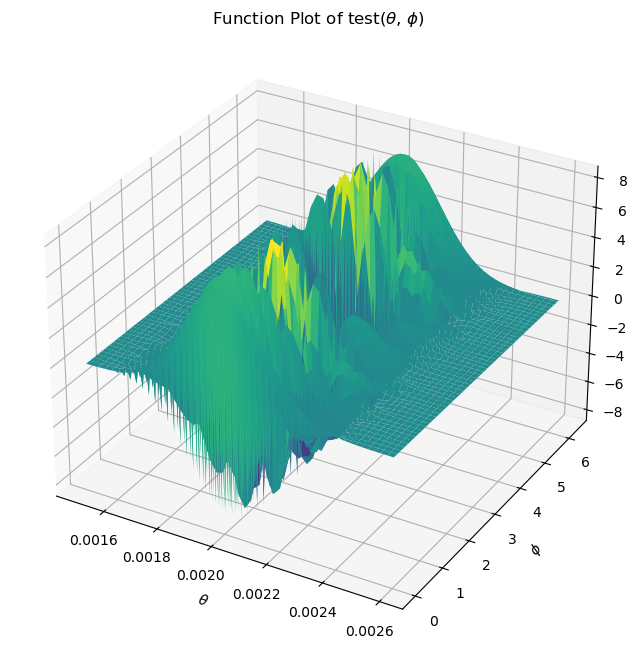

In [64]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

@jit(nopython=True)
def M(epsilon,theta,phi,s,epsilon_f,theta_f,phi_f,s_f,omega,theta_k,phi_k,lamb):

    photon_polar_slash_=photon_polar_slash(lamb,theta_k,phi_k)
    four_vec_slash_k=four_vec_slash(omega,0,theta_k,phi_k)
    three_vec_i=three_vec(epsilon,me,theta,phi)
    three_vec_f=three_vec(epsilon_f,me,theta_f,phi_f)
    three_vec_k=three_vec(omega,0,theta_k,phi_k)

    res=1/((three_vec_f+three_vec_k-three_vec_i)@(three_vec_f+three_vec_k-three_vec_i))*\
                        u_f(epsilon_f,theta_f,phi_f,s_f)@\
                        (1/(2*(omega*epsilon_f-three_vec_k@three_vec_f))*photon_polar_slash_@\
                        (four_vec_slash(epsilon_f,me,theta_f,phi_f)+four_vec_slash_k+me*I_4)@gamma0\
                        +\
                        1/(-2*(omega*epsilon-three_vec_k@three_vec_i))*gamma0@\
                        (four_vec_slash(epsilon,me,theta,phi)-four_vec_slash_k+me*I_4)@photon_polar_slash_)@\
                        u(epsilon,theta,phi,s)
    return res[0]

 

@jit(nopython=True)
def curl_L_pre_plt(theta,phi,s,epsilon_f,theta_f,phi_f,s_f,omega,theta_k,phi_k,lamb):
    epsilon=epsilon_f+omega
    p_mod=np.sqrt(epsilon**2-me**2)
    three_vec_res = three_vec(epsilon, me, theta, phi).astype(np.complex128)
    res=p_mod*np.sin(theta)*Phi_cap(epsilon,theta,phi,l)*np.exp(-1j*b_perp@three_vec_res)\
        *M(epsilon,theta,phi,s,epsilon_f,theta_f,phi_f,s_f,omega,theta_k,phi_k,lamb)
    return res*C_in

def test(theta,phi):
    res=curl_L_pre_plt(theta,phi,0.5,3.026,np.pi/2,np.pi/3,0.5,2,np.pi/3,np.pi/3,1)
    return res.real


# 生成 theta 和 phi 的数据
theta_vals = np.linspace(0.0015, 0.0026, 50)  # 从 0 到 pi
phi_vals = np.linspace(0, 2*np.pi, 100)  # 从 0 到 2*pi
theta, phi = np.meshgrid(theta_vals, phi_vals)

# 计算 test 函数值
# 用 numpy 的 `frompyfunc` 确保 `test` 逐元素计算
z = np.frompyfunc(test, 2, 1)(theta, phi).astype(np.float64)  # 关键部分


# 创建图形
fig = plt.figure(figsize=(10, 8))

# 选择绘制方式(取消注释你想要的)

## 方式 1: 3D 曲面图
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(theta, phi, z, cmap='viridis')
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\phi$')
ax.set_zlabel(r'test($\theta$, $\phi$)')

## 方式 2: 等高线图(如果需要 2D 视图)
# ax = fig.add_subplot(111)
# contour = ax.contourf(theta, phi, z, levels=50, cmap='viridis')
# fig.colorbar(contour)
# ax.set_xlabel(r'$\theta$')
# ax.set_ylabel(r'$\phi$')

plt.title("Function Plot of test($\\theta$, $\\phi$)")
plt.show()


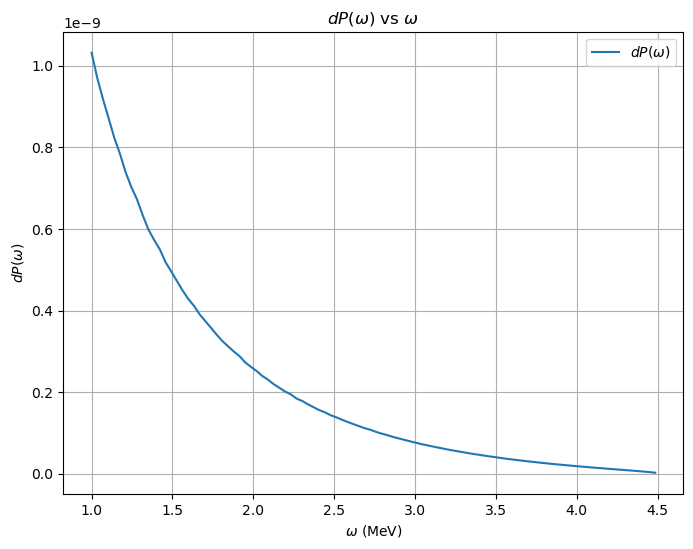

In [5]:
# 关于omega 的能谱图
import numpy as np
import matplotlib.pyplot as plt

# 1. 读取 .npz 文件
data = np.load('res_0221_135145.npz')

# 2. 提取数据
omega_values = data['omega_values']
P_values = data['results']

# 创建图形
fig = plt.figure(figsize=(8, 6))
# 3. 绘制图表
plt.plot(omega_values, P_values, label=r'$dP(\omega)$')
plt.xlabel(r'$\omega$ (MeV)')
plt.ylabel(r'$dP(\omega)$')
plt.title(r'$dP(\omega)$ vs $\omega$')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# 关于omega 的能谱图
import numpy as np
import matplotlib.pyplot as plt

# 1. 读取 .npz 文件
data = np.load('.npz')

# 2. 提取数据
theta_k_vals = data['theta_k_vals']
P_vals = data['results']

# 创建图形
fig = plt.figure(figsize=(8, 6))
# 3. 绘制图表
plt.plot(theta_k_vals, P_vals)
plt.xlabel(r'$\theta_k$ ')
plt.ylabel(r'$dP(theta_k)$')
plt.title(r'$\omega=2$')
plt.legend()
plt.grid(True)
plt.show()